In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1> A Markov matrix (or stochastic matrix) </h1>

<p> Gives the probability of reaching a set of states given a set of starting states. Here's a basic example of what such a Markov chain would look if we wanted to model the weather in the evening given the weather in the morning: </p>

<img src="markov.png">

The starting "state" is listed on the left, while the column gives the final outcome. If we wanted to know the probability of Evening Sun given that it there was Morning rain, we would get 0.25 - a 25% chance of that outcome. Note that each row of this matrix is normalized, a statement that if you start in a state, there is a 100% chance that something happens. Nothing tricky here.


We can use this concept to build 

In [2]:
np.random.seed(30)
characters = list('abcdefghijklmnopqrstuvwxyz ')
cipher     = np.random.permutation(characters)

In [3]:
# take jumbled code to english
correct_map  = {code:   actual for code, actual in zip(cipher, characters)}
# take english to jumbled code
jumbler      = {actual: code for code, actual in correct_map.items()}
# indices of correct english
alpha_lookup = {letter: i for i, letter in enumerate(characters)}

In [4]:
def clean_chapter(doc):
    intermediate = re.sub(r'[^a-z]', ' ', doc)  
    return re.sub(r"\s\s+", " ", intermediate)

In [5]:
def combine_chapters(chapters):
    docs = [np.loadtxt(f'./moby_dick/chapter_{chap}.txt', dtype=str) for chap in chapters]
    docs = [" ".join(doc) for doc in docs]
    docs = [clean_chapter(doc) for doc in docs]
    return " ".join(docs)

In [6]:
train_chapters = combine_chapters(np.arange(1, 40))
test_chapters  = combine_chapters([50, 60])

test_chapters[:100]

'chapter the hyena there are certain queer times and occasions in this strange mixed affair we call l'

In [7]:
def make_cooccurrence_matrix(corpus, smooth_factor=0.01):
    """
    Matrix of counts
    
    first index is starting char, 
    second is following char
    """
    counts = np.zeros(shape=(len(characters), len(characters)))
    last = None
    for index, char in enumerate(corpus):
        if index == 0:
            last = alpha_lookup[char]
            continue
            
        current = alpha_lookup[char]
        counts[last, current] += 1
        last = current
    
    return counts + smooth_factor

In [8]:
def make_transition_matrix(corpus, smooth_factor=0.01):
    mx = make_cooccurrence_matrix(corpus, smooth_factor)
    total_ocs = np.sum(mx, axis=1).reshape(-1, 1)
    return mx / total_ocs

In [9]:
transition_matrix = make_transition_matrix(train_chapters)

In [10]:
# these should be about the same (up to a smoothing factor)
# this is the fraction of times 'b' follows 'a'
transition_matrix[0, 1], train_chapters.count('ab') / train_chapters.count('a')

(0.028496143625383514, 0.02849604221635884)

In [11]:
def logprob(train_transition_matrix, observation):
    observed_counts = make_cooccurrence_matrix(observation, smooth_factor=0)
    i, j = np.where(observed_counts)
    return np.sum(np.log(train_transition_matrix[i, j]) * observed_counts[i, j])

In [12]:
logprob(transition_matrix, train_chapters)

-782412.05505489

In [13]:
logprob(transition_matrix, test_chapters)

-23044.594824000356

MCMC steps:

    1) pick random cipher
    Until convergence:
        2) decode text
        3) calculate log likelihood
        4) use MH criterion to decide whether to keep new cipher

In [14]:
def decipher_string(ciphered_string, decoder):
    """
    Decode a ciphered text.
    
    Decoder: dict mapping {ciphered char: unciphered char}
    """
    new_str = ''
    
    for char in ciphered_string:
        new_str += decoder[char]
        
    return new_str


In [15]:
def encipher_message(unciphered_string, encoder):
    return decipher_string(unciphered_string, encoder)

In [16]:
def propose_cipher(original_cipher):
    """
    Swap two elements of the cipher at random
    """
    new_cipher = original_cipher.copy()
    char1, char2 = np.random.choice(characters, size=2, replace=False)
    
    char1_val = original_cipher[char1]
    char2_val = original_cipher[char2]
    
    new_cipher[char1] = char2_val
    new_cipher[char2] = char1_val
    
    return new_cipher

In [17]:
start_cipher = {ciph: actual for actual, ciph in 
                zip(np.random.choice(characters, size=27, replace=False), np.random.choice(characters, size=27, replace=False))}
ciphered_doc = encipher_message(test_chapters, start_cipher)

In [18]:
test_chapters[:100]

'chapter the hyena there are certain queer times and occasions in this strange mixed affair we call l'

In [19]:
ciphered_doc[:100]

'sthrlqpgltqgtxqkhgltqpqghpqgsqplhwkgceqqpglwzq ghkmgassh wak gwkgltw g lphkdqgzwuqmghoohwpgiqgshbbgb'

In [20]:
def accept_proposed_cipher(proposed_loglike, original_loglike):
    prob_ratio = np.exp(proposed_loglike - original_loglike)
    uniform_random = np.random.random()
    
    return prob_ratio > uniform_random

In [21]:
n_iterations = 2500
current_cipher = start_cipher
likes = []

for cycle in range(n_iterations):
    prop_cipher = propose_cipher(current_cipher)
    prop_decoded_text = decipher_string(ciphered_doc, prop_cipher)
    
    if cycle % 20 == 0:
        print("\nCycle:", cycle, prop_decoded_text[:100])
        
    og_decoded_text = decipher_string(ciphered_doc, current_cipher)
    
    prop_loglike = logprob(transition_matrix, prop_decoded_text)
    og_loglike  = logprob(transition_matrix, og_decoded_text)
    
    if accept_proposed_cipher(proposed_loglike=prop_loglike, original_loglike=og_loglike):
        current_cipher = prop_cipher
        likes += [prop_loglike]
    else:
        likes += [og_loglike]


Cycle: 0  ltpbcrdblcdlucvtdblcrcdtrcd crbtivdsqccrdbifcgdtvzdy  tgiyvgdivdbligdgbrtvmcdfieczdtaatirdwcd thhdh


/usr/local/anaconda3/envs/data-science-environment/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



Cycle: 20  ltbcirucliuldihtucliriutriu irctshunoiirucsfieuthzuy  tesyheushuclseuecrthmiufsgizutpptsrujiu taaua

Cycle: 40  etbciruceiuedihtuceiriutriu irctshunoiirucsfiluthzuy  tlsyhlushuceslulcrthmiufsgizutpptsrujiu taaua

Cycle: 60 tc feirueciucdih ueciriu riutire ahunoiirueabilu hzuytt layhluahuecaluler hkiubagizu pp arujiut ssus

Cycle: 80 ncqfuir uci cpihq uciri qri niruqah toiir uazil qhb ynnqlayhl ah ucal lurqhmi zagib qddqar ji nqss s

Cycle: 100 nrefuic uri rhipe urici eci nicueap toiic uazil epb ynnelaypl ap ural lucepmi zakib eddeac ji ness s

Cycle: 120 ncewuir uci cpike uciri eri nirueak toiir uazis ekb ynnesayks ak ucas surekmi zahib eddear ji nell l

Cycle: 140 ncahlir lci ckipa lciri ari nirlaep moiir lezis apb ynnaseyps ep lces slrapti zevib addaer ji nauu u

Cycle: 160 kcahtir tci cnipa tciri ari kirtaep moiir tezis apb ykkaseyps ep tces strapui zevib addaer wi kall l

Cycle: 180 ncaftis tci ckipa tcisi asi nistaep moiis tezir apb ynnareypr ep tcer rtsapui zevib adda


Cycle: 1480 chabterstheshyenastheresarescertainsqueerstime sandsocca ion sinsthi s trangesmixedsaffairswescallsl

Cycle: 1500 chabtergtheghyenagtheregaregcertaingqueergtimesgandgoccasionsgingthisgstran egmixedgaffairgwegcallgl

Cycle: 1520 yhabter the hcena there are yertain queer times and oyyasions in this strange mixed affair we yall l

Cycle: 1540 chaptre thr hyrna threr aer cretain qurre timrs and occasions in this steangr mixrd affaie wr call l

Cycle: 1560 chdpter the hyend there dre certdin queer times dna occdsions in this strdnge mixea dffdir we cdll l

Cycle: 1580 chapter the hyena there are certadn queer tdmes ani occasdons dn thds strange mdxei affadr we call l

Cycle: 1600 chqpter the hyenq there qre certqin aueer times qnd occqsions in this strqnge mixed qffqir we cqll l

Cycle: 1620 chapter the hyena there are certain queer timex and occaxionx in thix xtrange mised affair we call l

Cycle: 1640 chaptev the hyena theve ave cevtain queev times and occasions in this stvan

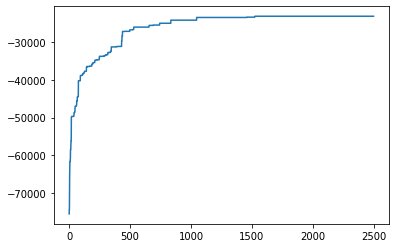

In [22]:
plt.plot(likes);

In [24]:
decipher_string(ciphered_doc, current_cipher)

'chapter the hyena there are certain queer times and occasions in this strange mixed affair we call life when a man takes this whole universe for a vast practical joke though the wit thereof he but dimly discerns and more than suspects that the joke is at nobody s expense but his own however nothing dispirits and nothing seems worth while disputing he bolts down all events all creeds and beliefs and persuasions all hard things visible and invisible never mind how knobby as an ostrich of potent digestion gobbles down bullets and gun flints and as for small difficulties and worryings prospects of sudden disaster peril of life and limb all these and death itself seem to him only sly good natured hits and jolly punches in the side bestowed by the unseen and unaccountable old joker that odd sort of wayward mood i am speaking of comes over a man only in some time of extreme tribulation it comes in the very midst of his earnestness so that what just before might have seemed to him a thing mos